In [1]:
import pandas as pd
import numpy as np
import random

def adjust_time(time_str, offset_seconds=0):
    # This function now handles the time adjustment with a default offset of zero.
    time_str = time_str.strip()
    parts = time_str.split(':')
    hours, minutes, seconds = int(parts[0]), int(parts[1]), int(parts[2])
    if hours >= 24:  # Correct hours that roll over
        hours -= 24
    # Calculate total seconds
    total_seconds = hours * 3600 + minutes * 60 + seconds + offset_seconds
    total_seconds %= 86400  # Wrap around midnight
    new_hours = total_seconds // 3600
    new_minutes = (total_seconds % 3600) // 60
    new_seconds = total_seconds % 60
    return f"{new_hours:02}:{new_minutes:02}:{new_seconds:02}"

# Load data
stops_df = pd.read_csv('../inputs/gtfs_line_2_stops_upward_12.csv')
stop_times_df = pd.read_csv('../inputs/gtfs_line_2_stop_times_upward_12.csv')

# Correct and convert time data for accurate calculations
stop_times_df['arrival_time'] = stop_times_df['arrival_time'].apply(lambda x: adjust_time(x))  # Adjust without offset
stop_times_df['departure_time'] = stop_times_df['arrival_time'].apply(lambda x: adjust_time(x))  # Initially the same as arrival

stop_times_df['arrival_time'] = pd.to_datetime(stop_times_df['arrival_time'], format='%H:%M:%S').dt.time
stop_times_df['departure_time'] = pd.to_datetime(stop_times_df['departure_time'], format='%H:%M:%S').dt.time

# Adjust times in stop_times_df for entry and deal times
stop_times_df['adjusted_entry_time'] = stop_times_df['arrival_time'].apply(lambda x: adjust_time(x.strftime('%H:%M:%S'), -random.randint(120, 300)))
stop_times_df['adjusted_departure_time'] = stop_times_df['arrival_time'].apply(lambda x: adjust_time(x.strftime('%H:%M:%S'), random.randint(90, 300)))

# Convert the adjusted times back to datetime.time
stop_times_df['adjusted_entry_time'] = pd.to_datetime(stop_times_df['adjusted_entry_time'], format='%H:%M:%S').dt.time
stop_times_df['adjusted_departure_time'] = pd.to_datetime(stop_times_df['adjusted_departure_time'], format='%H:%M:%S').dt.time

# Define simulation parameters
total_passengers = 500000
rush_hour_multiplier = 3
rush_hours = [(6.5, 9.5), (15.5, 18.5)]

def calculate_weights(times, rush_hours, multiplier):
    # Convert datetime.time objects to hours as floats for easier comparison
    hours = times.apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)
    
    # Initialize weights to 1
    weights = np.ones(len(times))
    
    # Apply rush hour multiplier
    for start, end in rush_hours:
        # Update weights for times within rush hour periods
        weights[(hours >= start) & (hours <= end)] *= multiplier
    
    return weights

def generate_od_pairs(num_trips, stop_times, rush_hours, rush_hour_multiplier):
    od_pairs = []
    for _ in range(num_trips):
        # Convert adjusted entry times to datetime.time for proper comparison
        stop_times['adjusted_entry_time_dt'] = pd.to_datetime(stop_times['adjusted_entry_time'], format='%H:%M:%S').dt.time
        
        # Calculate weights based on rush hours
        weights = calculate_weights(stop_times['adjusted_entry_time_dt'], rush_hours, rush_hour_multiplier)
        
        # Sample an entry record with weighted probabilities
        entry_record = stop_times.sample(1, weights=weights)
        origin = entry_record['stop_id'].iloc[0]
        trip_id = entry_record['trip_id'].iloc[0]
        stop_sequence = entry_record['stop_sequence'].iloc[0]
        entry_datetime = pd.to_datetime(entry_record['adjusted_entry_time'].iloc[0], format='%H:%M:%S')

        # Filter potential destination points
        potential_destinations = stop_times[
            (stop_times['trip_id'] == trip_id) 
            # &
            # (stop_times['stop_sequence'] > stop_sequence)
        ]

        if not potential_destinations.empty:
            potential_dest = potential_destinations.sample(1)
            if (potential_dest['stop_sequence'].iloc[0] < stop_sequence):
                continue
            deal_record = potential_dest
            destination = deal_record['stop_id'].iloc[0]
            deal_datetime = pd.to_datetime(deal_record['adjusted_departure_time'].iloc[0], format='%H:%M:%S')

            travel_time = round((deal_datetime - entry_datetime).total_seconds() / 60)
            if travel_time >= 0:
                od_pairs.append({
                    'date': '2024-07-09',
                    'weekday': 2,
                    'hour': entry_datetime.hour,
                    'entry_time': entry_datetime.strftime('%H:%M:%S'),
                    'deal_time': deal_datetime.strftime('%H:%M:%S'),
                    'enter_station': origin,
                    'exit_station': destination,
                    'travel_time': travel_time,
                    'exit_type': 0,
                    'departure_time': deal_datetime.strftime('%H:%M:%S'),
                    # 'route_num': entry_record['route_num'].values[0],
                    'route_id': entry_record['route_id'].values[0],
                    'stop_num': entry_record['stop_num'].values[0],
                })

    return pd.DataFrame(od_pairs)

# Generate data for rush and non-rush hours
od_data = generate_od_pairs(total_passengers, stop_times_df, rush_hours, rush_hour_multiplier)

# Save to CSV
od_data.to_csv('../inputs/od_line_2_weekday_12_.csv', index=False)
print("Synthetic OD data generated and saved. Shape:", od_data.shape)

Synthetic OD data generated and saved. Shape: (271204, 12)


Number of travelers between 07:00:00 and 09:00:00: 70133
Number of travelers between 15:30:00 and 18:00:00: 64448
Total number of travelers during rush hours (morning + evening): 134581
Total travelers in the day: 271204


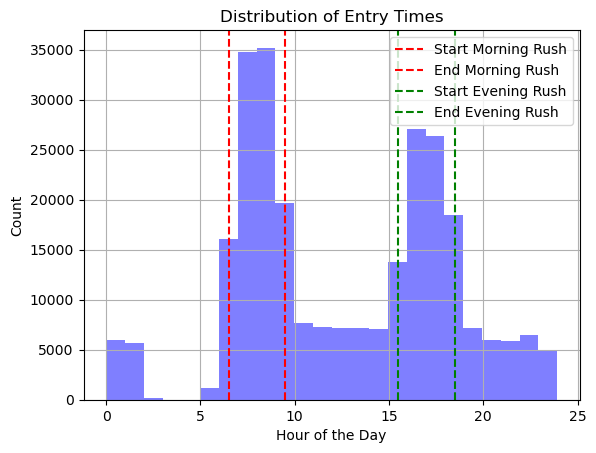

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
times_df = pd.read_csv('../inputs/od_line_2_weekday_12_.csv')

# Convert adjusted_entry_time to datetime.time for easier manipulation
times_df['adjusted_entry_time_dt'] = pd.to_datetime(times_df['entry_time'], format='%H:%M:%S').dt.time

# Define the morning and evening time ranges
start_time_morning = pd.to_datetime('07:00:00', format='%H:%M:%S').time()
end_time_morning = pd.to_datetime('09:00:00', format='%H:%M:%S').time()
start_time_evening = pd.to_datetime('15:30:00', format='%H:%M:%S').time()
end_time_evening = pd.to_datetime('18:00:00', format='%H:%M:%S').time()

# Filter entries within the specified morning and evening time ranges
filtered_entries_morning = times_df[(times_df['adjusted_entry_time_dt'] >= start_time_morning) & (times_df['adjusted_entry_time_dt'] <= end_time_morning)]
filtered_entries_evening = times_df[(times_df['adjusted_entry_time_dt'] >= start_time_evening) & (times_df['adjusted_entry_time_dt'] <= end_time_evening)]

# Combine morning and evening entries for total rush hour count
combined_rush_hour_entries = pd.concat([filtered_entries_morning, filtered_entries_evening])

# Count the number of entries
entry_count_morning = len(filtered_entries_morning)
entry_count_evening = len(filtered_entries_evening)
total_rush_hour_entries = len(combined_rush_hour_entries)
total_entries = len(times_df)

print(f'Number of travelers between {start_time_morning} and {end_time_morning}: {entry_count_morning}')
print(f'Number of travelers between {start_time_evening} and {end_time_evening}: {entry_count_evening}')
print(f'Total number of travelers during rush hours (morning + evening): {total_rush_hour_entries}')
print(f'Total travelers in the day: {total_entries}')

# Optionally, you can visualize the distribution of entry times
times_in_hours = times_df['adjusted_entry_time_dt'].apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)
plt.hist(times_in_hours, bins=24, alpha=0.5, color='blue')
plt.title('Distribution of Entry Times')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.axvline(x=6.5, color='r', linestyle='--', label='Start Morning Rush')
plt.axvline(x=9.5, color='r', linestyle='--', label='End Morning Rush')
plt.axvline(x=15.5, color='g', linestyle='--', label='Start Evening Rush')
plt.axvline(x=18.5, color='g', linestyle='--', label='End Evening Rush')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import random

def adjust_time(time_str, offset_seconds=0):
    # This function now handles the time adjustment with a default offset of zero.
    time_str = time_str.strip()
    parts = time_str.split(':')
    hours, minutes, seconds = int(parts[0]), int(parts[1]), int(parts[2])
    if hours >= 24:  # Correct hours that roll over
        hours -= 24
    # Calculate total seconds
    total_seconds = hours * 3600 + minutes * 60 + seconds + offset_seconds
    total_seconds %= 86400  # Wrap around midnight
    new_hours = total_seconds // 3600
    new_minutes = (total_seconds % 3600) // 60
    new_seconds = total_seconds % 60
    return f"{new_hours:02}:{new_minutes:02}:{new_seconds:02}"

# Load data
stops_df = pd.read_csv('../inputs/gtfs_line_2_stops_upward.csv')
stop_times_df = pd.read_csv('../inputs/gtfs_line_2_stop_times_upward.csv')

# Correct and convert time data for accurate calculations
stop_times_df['arrival_time'] = stop_times_df['arrival_time'].apply(lambda x: adjust_time(x))  # Adjust without offset
stop_times_df['departure_time'] = stop_times_df['arrival_time'].apply(lambda x: adjust_time(x))  # Initially the same as arrival

stop_times_df['arrival_time'] = pd.to_datetime(stop_times_df['arrival_time'], format='%H:%M:%S').dt.time
stop_times_df['departure_time'] = pd.to_datetime(stop_times_df['departure_time'], format='%H:%M:%S').dt.time


# # Adjust times in stop_times_df for entry and deal times using a normal distribution
# # Ensure that the times don't go beyond the bounds you set by using clip method
# normal_entry_offset = np.random.normal(loc=-150, scale=50, size=len(stop_times_df))
# normal_departure_offset = np.random.normal(loc=12, scale=8, size=len(stop_times_df))

# # Applying the normal offsets
# stop_times_df['adjusted_entry_time'] = stop_times_df['arrival_time'].apply(
#     lambda x: adjust_time(x.strftime('%H:%M:%S'), int(normal_entry_offset.pop(0))))

# stop_times_df['adjusted_departure_time'] = stop_times_df['arrival_time'].apply(
#     lambda x: adjust_time(x.strftime('%H:%M:%S'), int(normal_departure_offset.pop(0))))

# Adjust times in stop_times_df for entry and deal times
stop_times_df['adjusted_entry_time'] = stop_times_df['arrival_time'].apply(lambda x: adjust_time(x.strftime('%H:%M:%S'), -random.randint(120, 300)))
stop_times_df['adjusted_departure_time'] = stop_times_df['arrival_time'].apply(lambda x: adjust_time(x.strftime('%H:%M:%S'), random.randint(90, 300)))

# Convert the adjusted times back to datetime.time
stop_times_df['adjusted_entry_time'] = pd.to_datetime(stop_times_df['adjusted_entry_time'], format='%H:%M:%S').dt.time
stop_times_df['adjusted_departure_time'] = pd.to_datetime(stop_times_df['adjusted_departure_time'], format='%H:%M:%S').dt.time

# Define simulation parameters
total_passengers = 1100000
rush_hour_multiplier = 3
rush_hours = [(7, 9.5), (15.5, 18)]

# Generate pairs ensuring travel times are reasonable
def generate_od_pairs(num_trips, stops, stop_times):
    od_pairs = []
    for _ in range(num_trips):
        origin = random.choice(stops['stop_id'])
        destination = random.choice(stops['stop_id'])
        while origin == destination:
            destination = random.choice(stops['stop_id'])

        origin_times = stop_times[stop_times['stop_id'] == origin]
        destination_times = stop_times[stop_times['stop_id'] == destination]

        pair_found = False  # Flag to stop after finding the first valid pair
        for _ in range(100):
            if pair_found:
                break
            if not origin_times.empty and not destination_times.empty:
                entry_record = origin_times.sample(1)
                entry_datetime = pd.to_datetime(entry_record['adjusted_entry_time'].values[0], format='%H:%M:%S')
                max_departure_datetime = entry_datetime + pd.Timedelta(hours=1)

                valid_dest_times = destination_times[
                    (pd.to_datetime(destination_times['adjusted_departure_time'], format='%H:%M:%S').dt.time >= entry_datetime.time()) &
                    (pd.to_datetime(destination_times['adjusted_departure_time'], format='%H:%M:%S').dt.time <= max_departure_datetime.time()) &
                    (destination_times['trip_id'] == entry_record['trip_id'].iloc[0]) &
                    (destination_times['stop_sequence'] > entry_record['stop_sequence'].iloc[0])  
                ]

                if not valid_dest_times.empty:
                    deal_record = valid_dest_times.sample(1)
                    deal_datetime = pd.to_datetime(deal_record['adjusted_departure_time'].values[0], format='%H:%M:%S')

                    travel_time = round((deal_datetime - entry_datetime).total_seconds() / 60)
                    if travel_time >= 0:
                        od_pairs.append({
                            'date': '2024-07-09',
                            'weekday': 2,
                            'hour': entry_datetime.hour,
                            'entry_time': entry_datetime.strftime('%H:%M:%S'),
                            'deal_time': deal_datetime.strftime('%H:%M:%S'),
                            'enter_station': origin,
                            'exit_station': destination,
                            'travel_time': travel_time,
                            'exit_type': 0,
                            'departure_time': deal_datetime.strftime('%H:%M:%S'),
                            # 'route_num': entry_record['route_num'].values[0],
                            'route_id': entry_record['route_id'].values[0]
                        })
                        pair_found = True  # Mark as found to prevent additional pairs for this passenger

    return pd.DataFrame(od_pairs)


# Generate data for rush and non-rush hours
od_data = generate_od_pairs(total_passengers, stops_df, stop_times_df)

# Save to CSV
od_data.to_csv('../inputs/od_line_2_weekday.csv', index=False)
print("Synthetic OD data generated and saved. Shape:", od_data.shape)